# MNIST using CNN

In [109]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import time
from sklearn.metrics import classification_report # for the evaluation

## Data Preprocessing

In [2]:
# source: https://www.kaggle.com/c/digit-recognizer/data
df = pd.read_csv('./digit-recognizer/train.csv')
print(df.shape)
df.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
y_train = df['label']
df_train = df.drop(columns=['label'])
df_train.shape

(42000, 784)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x16b5c5b38>]],
      dtype=object)

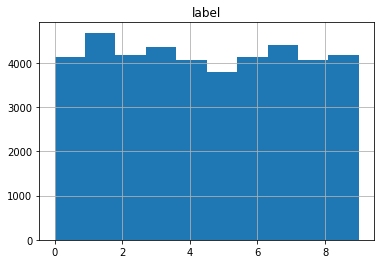

In [278]:
df[['label']].hist(bins=10, column=['label'])

In [95]:
size = 28
output_dim = len(y_train.unique())
output_dim

10

In [63]:
X = torch.tensor(df_train.values, dtype=torch.float16).view(df_train.shape[0],1,28,28) # this "1" is # of channels
Y = torch.tensor(y_train)

In [64]:
print(X.shape)
print(Y.shape)

torch.Size([42000, 1, 28, 28])
torch.Size([42000])


label:  tensor(0)


/Users/bayartsogt/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


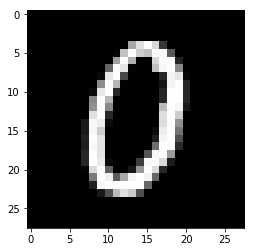

In [66]:
# Жишээ дата
data_id = 5
print('label: ', Y[data_id])
plt.imshow(torch.tensor(X[data_id].view(size,size), dtype=torch.int16), cmap='Greys_r') # 
plt.show()

In [229]:
n_test = 500
# train test split
train_x = X[:-n_test, :]
test_x = X[-n_test:, :]


train_y = Y[:-n_test]
test_y = Y[-n_test:]

print(train_x.shape)
print(test_x.shape)

print(train_y.shape)
print(test_y.shape)
# [[2, 3 ]
#  [4, -1]] -> 2x2 -> [4]

torch.Size([41500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([41500])
torch.Size([500])


In [345]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, stride=1, padding=0),
    nn.MaxPool2d(kernel_size=2),
    nn.ReLU(), # activation
    
    nn.Conv2d(in_channels=3, out_channels=5, kernel_size=4, stride=1, padding=0),
    nn.MaxPool2d(kernel_size=2),
    nn.ReLU(), # activation
    
    nn.Flatten(),
    nn.Linear(80, output_dim), # activation
    nn.Softmax()
)

print(model)

output = model(test_x.float()) # checking whether the dimension is correct or not.
output.shape

Sequential(
  (0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(3, 5, kernel_size=(4, 4), stride=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Flatten()
  (7): Linear(in_features=80, out_features=10, bias=True)
  (8): Softmax(dim=None)
)


torch.Size([500, 10])

In [346]:
# hyperparameters
lr=1e-3
batch_size = 256 # train_x.size()[0]//2
n_epoch = 30

In [347]:
train = TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)

# Mean Squared Error -> Loss ------------- < Cross Entropy Loss
criterian = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Adam, RMSProp

In [348]:
train_history = []
val_history = []
print('training...')
for epoch in range(1, n_epoch + 1):
    st = time()
    train_loss = 0
    for xb, yb in train_loader: # getting data by batch size
        
        optimizer.zero_grad()
        output = model(xb.float()) # outputs 10
        loss = criterian(output, yb)
        
        loss.backward()
        optimizer.step()
        # print(loss.item())
        train_loss += loss.item() * yb.shape[0]
        
    train_loss = train_loss/train_x.size()[0]
    train_history.append(train_loss)
    
    
    pred = model(test_x.float())
    val_loss = criterian(pred, test_y)
    val_history.append(val_loss.item())
    
    print(f"e {epoch}: {train_loss}, {val_loss.item()}, {time() - st} sec")

training...
e 1: 1.9401481731139034, 1.6746623516082764, 8.044788122177124 sec
e 2: 1.6502997740550214, 1.6204293966293335, 9.165642976760864 sec
e 3: 1.6244534164681492, 1.6136277914047241, 14.216531991958618 sec
e 4: 1.560565516724644, 1.521322250366211, 11.376054048538208 sec
e 5: 1.5148558248496917, 1.5095165967941284, 11.005910873413086 sec
e 6: 1.5094145948341093, 1.5042284727096558, 12.853904247283936 sec
e 7: 1.507361363698201, 1.5131779909133911, 10.982398986816406 sec
e 8: 1.5034779193947114, 1.5086911916732788, 11.475205898284912 sec
e 9: 1.5025203208693538, 1.49868905544281, 12.842241048812866 sec
e 10: 1.5011354635077787, 1.4907211065292358, 11.564473152160645 sec
e 11: 1.49858610981631, 1.4918583631515503, 12.999684810638428 sec
e 12: 1.497899968158768, 1.5009334087371826, 15.412351369857788 sec
e 13: 1.49660569190979, 1.498274803161621, 9.88134503364563 sec
e 14: 1.4968521567539996, 1.493396520614624, 9.53859281539917 sec
e 15: 1.4968332650173142, 1.498232364654541, 11.2

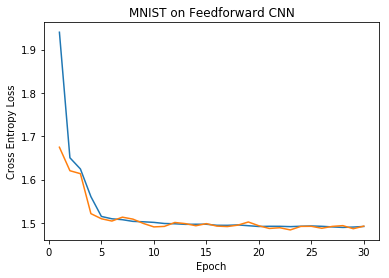

In [349]:
# plotting the trianing loss
plt.plot(range(1, n_epoch + 1), train_history)
plt.plot(range(1, n_epoch + 1), val_history)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('MNIST on Feedforward CNN')
plt.show()

In [350]:
pred = model(test_x.float()).clone().detach()

pred_ids = pred.argmax(1)
# print(test_y)
# print(pred_ids)
print(classification_report(test_y, pred_ids))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        46
           1       0.99      0.99      0.99        71
           2       0.97      0.95      0.96        41
           3       1.00      0.97      0.98        60
           4       0.95      1.00      0.97        55
           5       0.97      1.00      0.99        35
           6       0.98      0.96      0.97        48
           7       0.91      1.00      0.95        48
           8       1.00      0.93      0.96        43
           9       0.98      0.89      0.93        53

   micro avg       0.97      0.97      0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



predicted:  7


/Users/bayartsogt/env/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


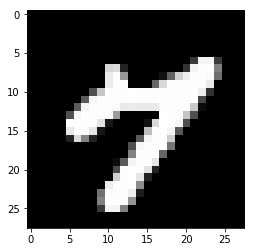

predicted:  1


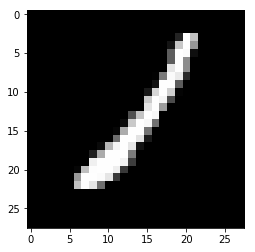

predicted:  9


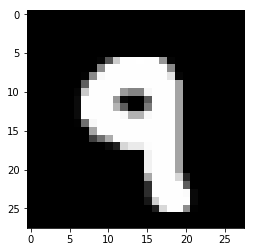

predicted:  3


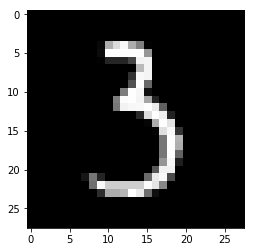

predicted:  9


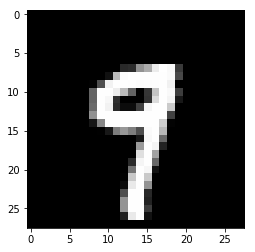

predicted:  4


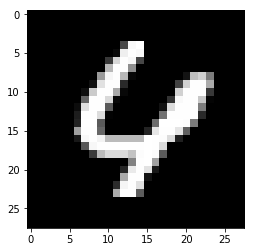

predicted:  8


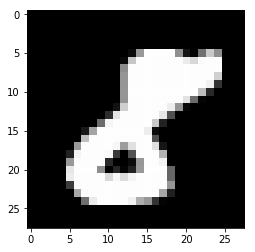

predicted:  8


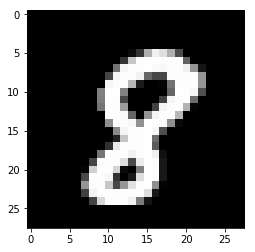

predicted:  0


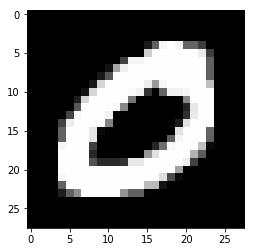

predicted:  4


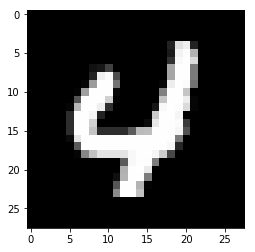

predicted:  2


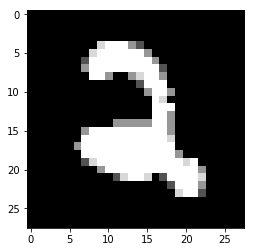

predicted:  1


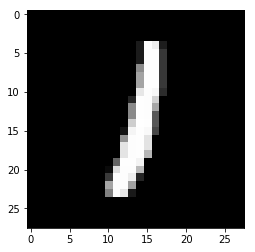

predicted:  3


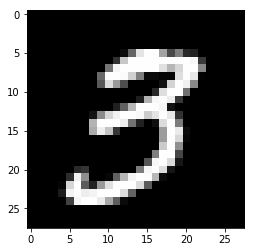

predicted:  0


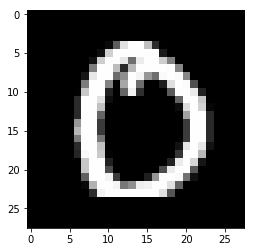

predicted:  3


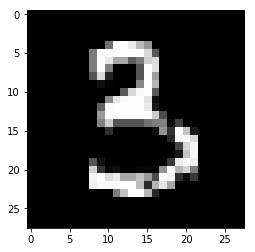

predicted:  3


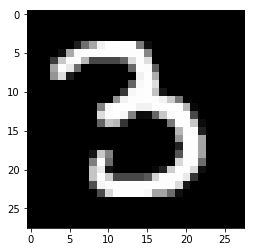

predicted:  4


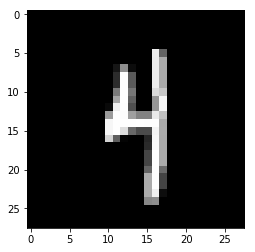

predicted:  5


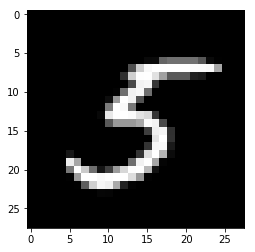

predicted:  8


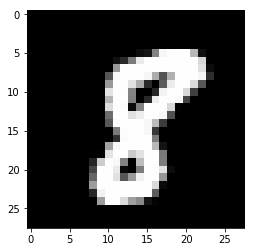

predicted:  2


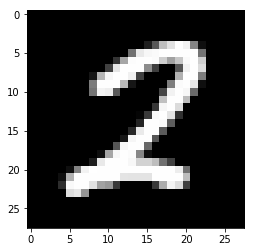

predicted:  7


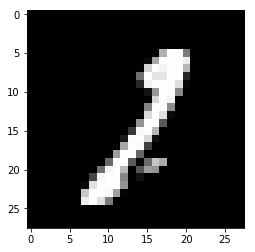

predicted:  1


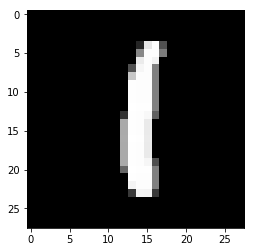

predicted:  0


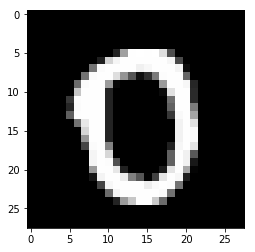

predicted:  6


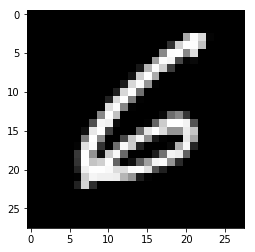

predicted:  1


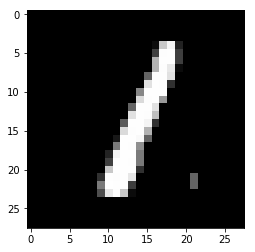

predicted:  1


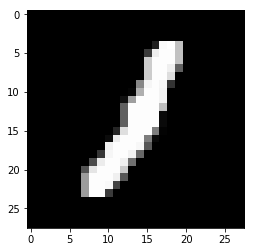

predicted:  5


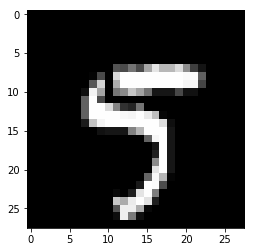

predicted:  1


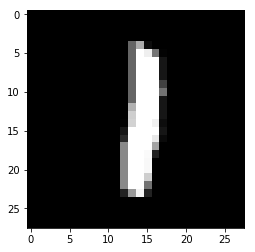

predicted:  5


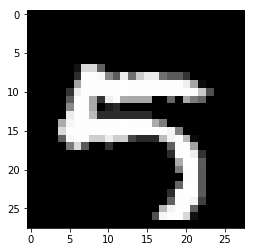

predicted:  3


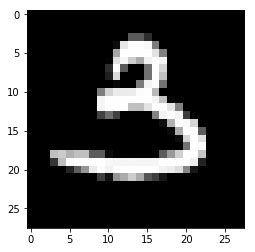

<Figure size 432x288 with 0 Axes>

In [352]:
# Жишээ дата
data_id = 10

for data_id in range(30):
    print("predicted: ", pred_ids[data_id].item())
    plt.imshow(torch.tensor(test_x[data_id].view(size,size), dtype=torch.int16), cmap='Greys_r')
    plt.show()
    plt.clf()

In [353]:
torch.save(model.state_dict(), 'cnn_test.pt')
print("model saved!")

model saved!


# Inference

In [358]:
import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [360]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, stride=1, padding=0),
    nn.MaxPool2d(kernel_size=2),
    nn.ReLU(), # activation
    
    nn.Conv2d(in_channels=3, out_channels=5, kernel_size=4, stride=1, padding=0),
    nn.MaxPool2d(kernel_size=2),
    nn.ReLU(), # activation
    
    nn.Flatten(),
    nn.Linear(80, output_dim), # activation
    nn.Softmax()
)

PATH = "cnn_test.pt"
model.load_state_dict(torch.load(PATH))
model.eval()

Sequential(
  (0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(3, 5, kernel_size=(4, 4), stride=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Flatten()
  (7): Linear(in_features=80, out_features=10, bias=True)
  (8): Softmax(dim=None)
)

In [354]:
from PIL import Image

In [361]:
im = Image.open("/Users/bayartsogt/Documents/projects/image-processing-labs/end-project/tsogoo/final_project_mnist/mnist/users_choice/wrong/3-1577025448.465846.png")
im = im.resize((28, 28))
im = np.array(im)[...,3]# .resize(28, 28)
print(im.shape)
test_tensor = torch.tensor(im.reshape(1, 1, 28, 28), dtype=torch.float32)

pred = model(test_tensor)
print(pred)
pred_ids = pred.argmax(1)
print(pred_ids)

(28, 28)
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 2.8473e-18, 1.4150e-40, 2.5513e-05,
         0.0000e+00, 1.0238e-31, 1.3539e-38, 9.9997e-01]],
       grad_fn=<SoftmaxBackward>)
tensor([9])


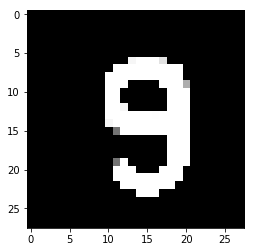

In [362]:
plt.imshow(im, cmap='Greys_r')